# MDN Examples

This notebook has some simple synthetic examples to validate the models. Two 1-D examples are from [this blog](https://towardsdatascience.com/a-hitchhikers-guide-to-mixture-density-networks-76b435826cca), the last example is a made up 2-D problem.

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from tqdm.notebook import tqdm
from multisensory_learning.models import MDN
from multisensory_learning.models.loss import mdn_loss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
import torch.distributions as D

dpi = 300
x_size = int(5600/dpi)
y_size = int(2900/dpi)

class MDNDataset(Dataset):
    
    def __init__(self, x, y):
        super().__init__()
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

# Linear Example

This is the 1-D linear example from [this blog](https://towardsdatascience.com/a-hitchhikers-guide-to-mixture-density-networks-76b435826cca).

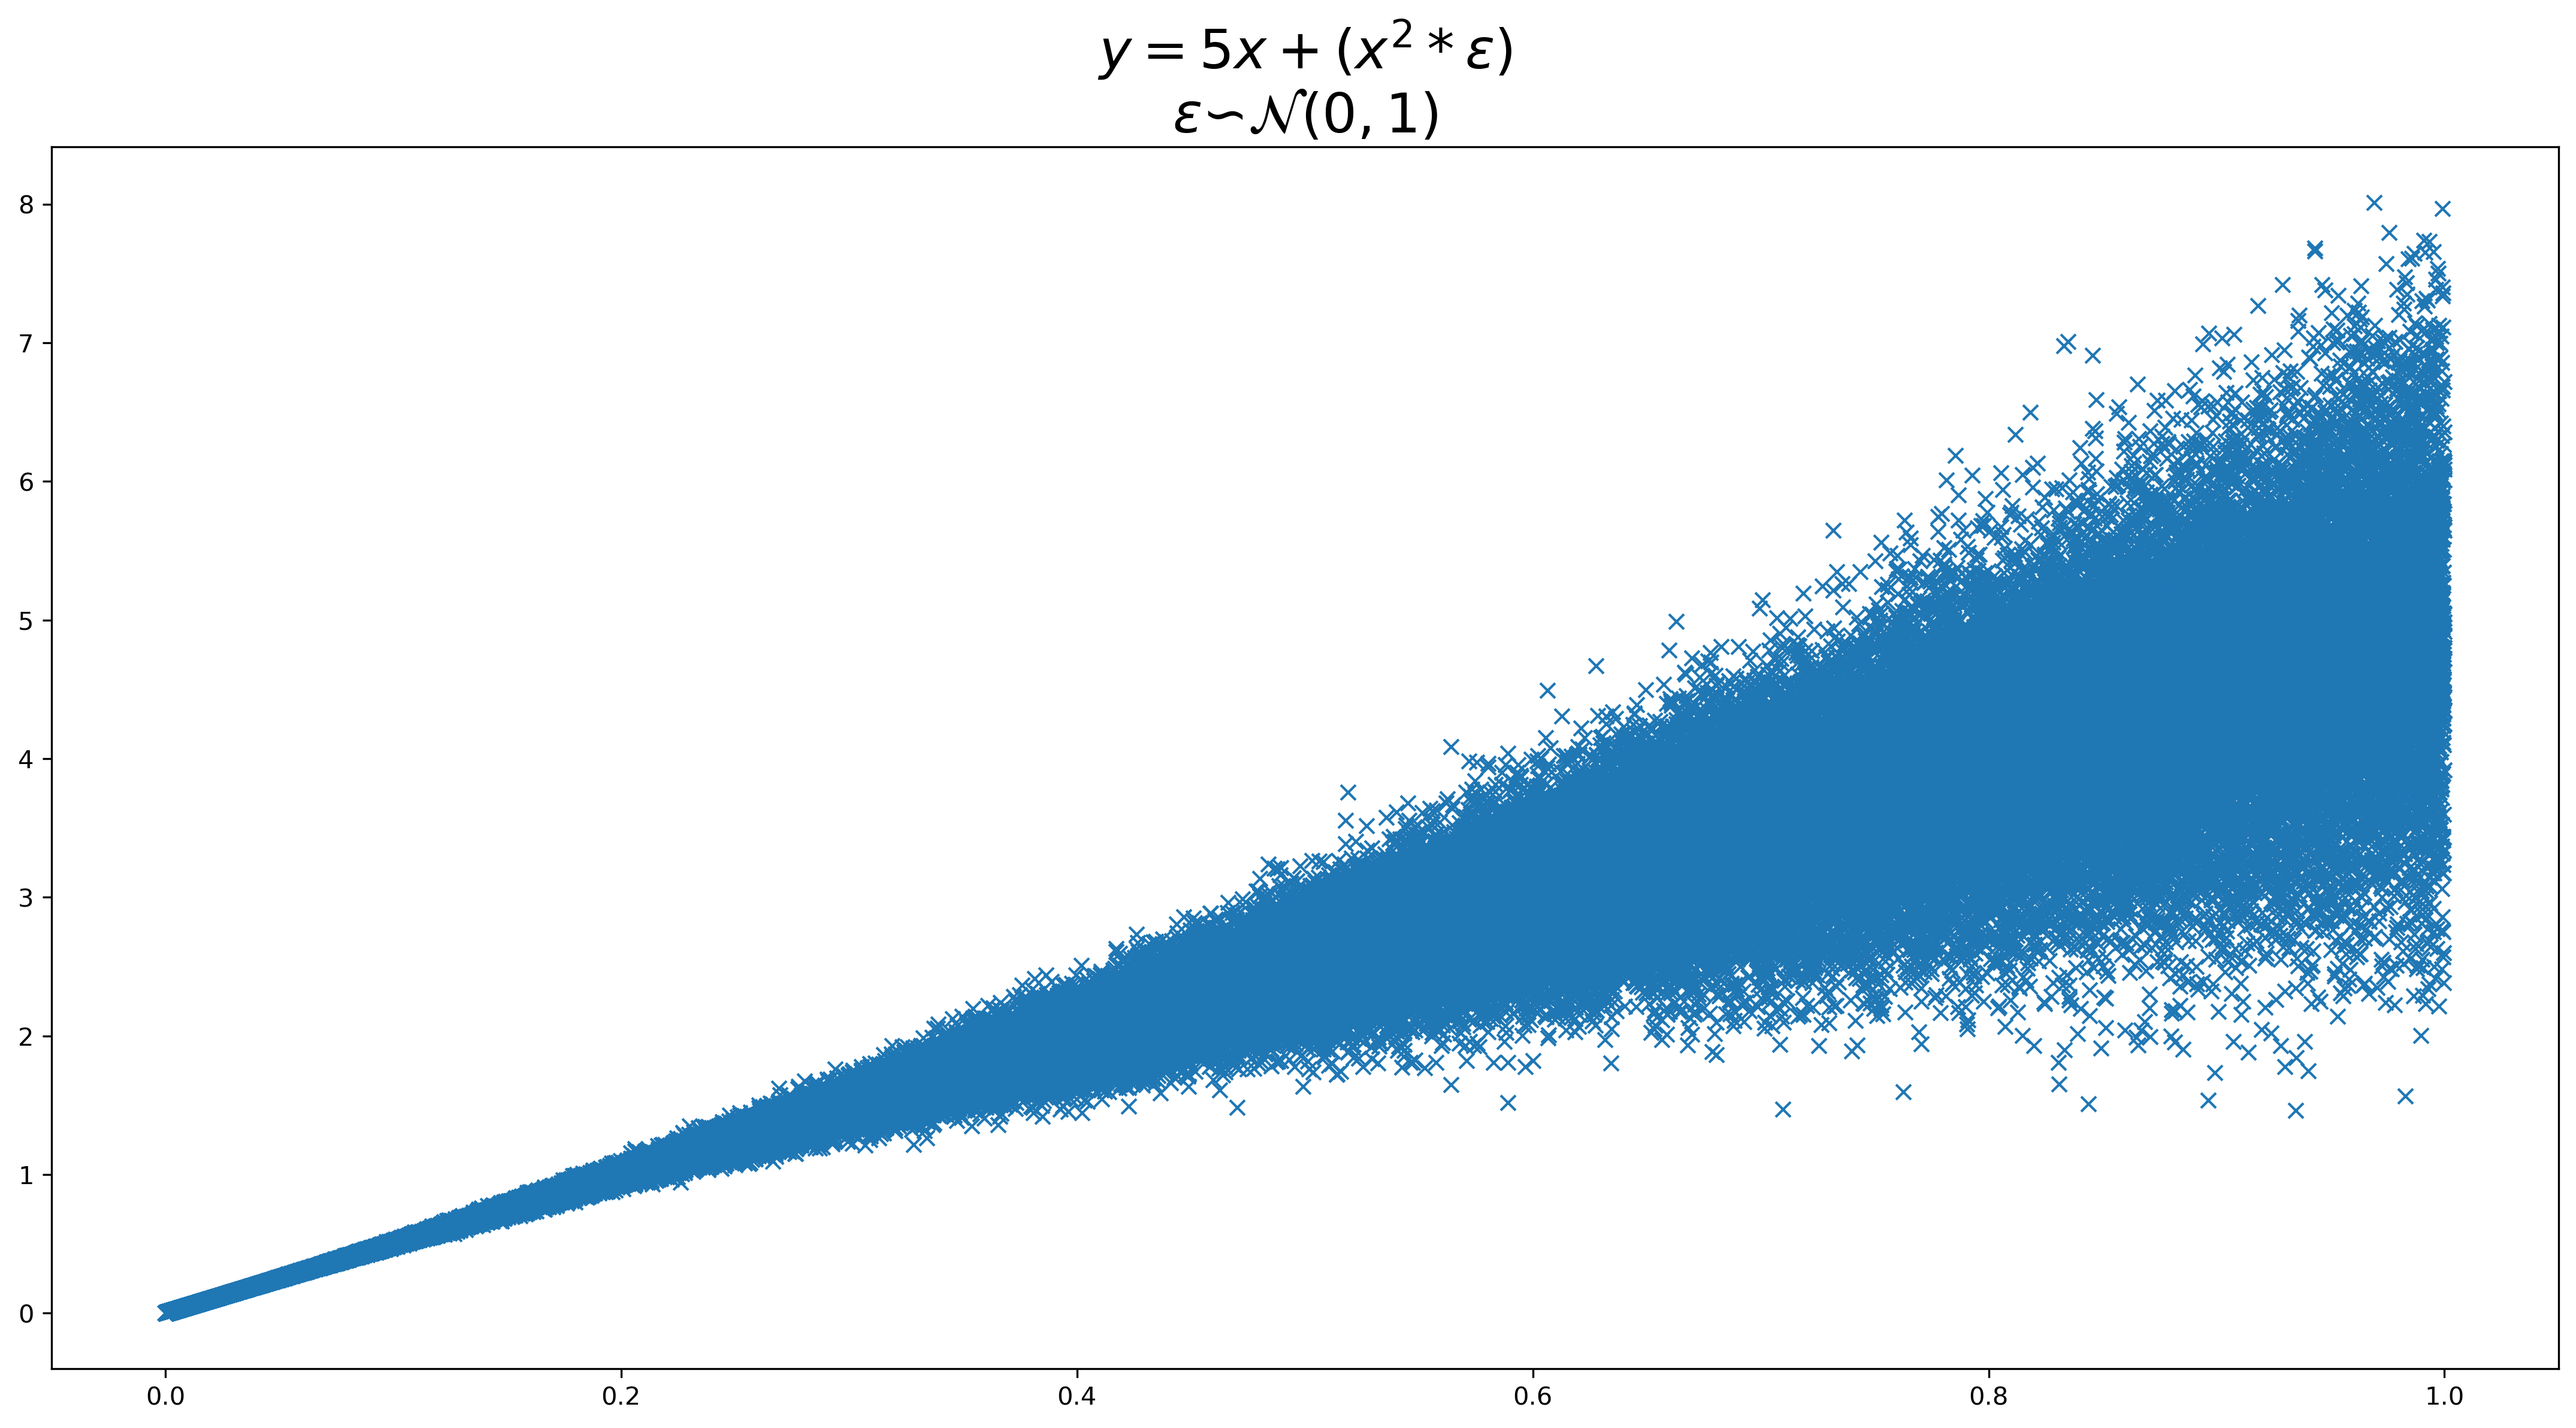

In [2]:
# Create training data
n_samples = 100000
linear_x = np.random.sample(n_samples)[:, np.newaxis]
linear_y = np.add(5*linear_x, np.multiply((linear_x)**2, np.random.standard_normal(linear_x.shape)))

fig = plt.figure(figsize=(x_size, y_size), dpi=dpi)
ax = plt.gca()
ax.set_title(r"$y = 5x + (x^2 * \epsilon)$"+"\n"+r"$\epsilon \backsim \mathcal{N}(0,1)$", fontsize=22)
ax.plot(linear_x, linear_y, "x",alpha=1., color=sns.color_palette()[0])
plt.show()

In [10]:
# Create model and data loader
device = 'cuda'
learning_rate = 1e-4
n_epochs = 100
batch_size = 2048
n_components = 1
n_hidden = 32
n_layers = 2
activation = 'relu'
norm = None

linear_dataset = MDNDataset(linear_x, linear_y)
linear_loader = DataLoader(linear_dataset, batch_size=batch_size, shuffle=True)

linear_mdn = MDN(1, 1, [n_hidden]*n_layers, n_components, activation, norm).to(device).double()
optim = Adam(linear_mdn.parameters(), lr=learning_rate)
linear_mdn.train()

MDN(
  (mlp): MLP(
    (layers): ModuleList(
      (0): LinearBlock(
        (layers): ModuleList(
          (0): Linear(in_features=1, out_features=32, bias=True)
          (1): ReLU()
        )
      )
      (1): LinearBlock(
        (layers): ModuleList(
          (0): Linear(in_features=32, out_features=32, bias=True)
          (1): ReLU()
        )
      )
      (2): LinearBlock(
        (layers): ModuleList(
          (0): Linear(in_features=32, out_features=32, bias=True)
        )
      )
    )
  )
  (alpha): LinearBlock(
    (layers): ModuleList(
      (0): Linear(in_features=32, out_features=1, bias=True)
    )
  )
  (mu): LinearBlock(
    (layers): ModuleList(
      (0): Linear(in_features=32, out_features=1, bias=True)
    )
  )
  (L_diag): LinearBlock(
    (layers): ModuleList(
      (0): Linear(in_features=32, out_features=1, bias=True)
      (1): Softplus(beta=1, threshold=20)
    )
  )
)

In [11]:
# Train the model
for epoch in range(n_epochs):
    running_loss = 0
    for x, y in linear_loader:
        alpha, mu, sigma_tril = linear_mdn(x.to(device))
        loss = mdn_loss(y.to(device), alpha, mu, sigma_tril)
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        running_loss += loss.item()
        
    print(f"E{epoch+1}: {running_loss / (epoch + 1):.3f}")

E1: 285.262
E2: 115.875
E3: 62.005
E4: 37.446
E5: 24.877
E6: 18.035
E7: 14.053
E8: 11.547
E9: 9.835
E10: 8.581
E11: 7.607
E12: 6.818
E13: 6.157
E14: 5.587
E15: 5.087
E16: 4.638
E17: 4.227
E18: 3.844
E19: 3.478
E20: 3.122
E21: 2.768
E22: 2.412
E23: 2.061
E24: 1.735
E25: 1.473
E26: 1.295
E27: 1.173
E28: 1.067
E29: 0.964
E30: 0.861
E31: 0.756
E32: 0.648
E33: 0.537
E34: 0.424
E35: 0.311
E36: 0.199
E37: 0.092
E38: -0.006
E39: -0.093
E40: -0.164
E41: -0.219
E42: -0.260
E43: -0.287
E44: -0.304
E45: -0.314
E46: -0.318
E47: -0.320
E48: -0.319
E49: -0.316
E50: -0.313
E51: -0.309
E52: -0.306
E53: -0.301
E54: -0.297
E55: -0.293
E56: -0.289
E57: -0.285
E58: -0.280
E59: -0.276
E60: -0.272
E61: -0.269
E62: -0.265
E63: -0.261
E64: -0.258
E65: -0.255
E66: -0.251
E67: -0.248
E68: -0.245
E69: -0.242
E70: -0.238
E71: -0.235
E72: -0.232
E73: -0.230
E74: -0.227
E75: -0.225
E76: -0.222
E77: -0.219
E78: -0.217
E79: -0.215
E80: -0.213
E81: -0.211
E82: -0.209
E83: -0.207
E84: -0.205
E85: -0.203
E86: -0.200
E87:

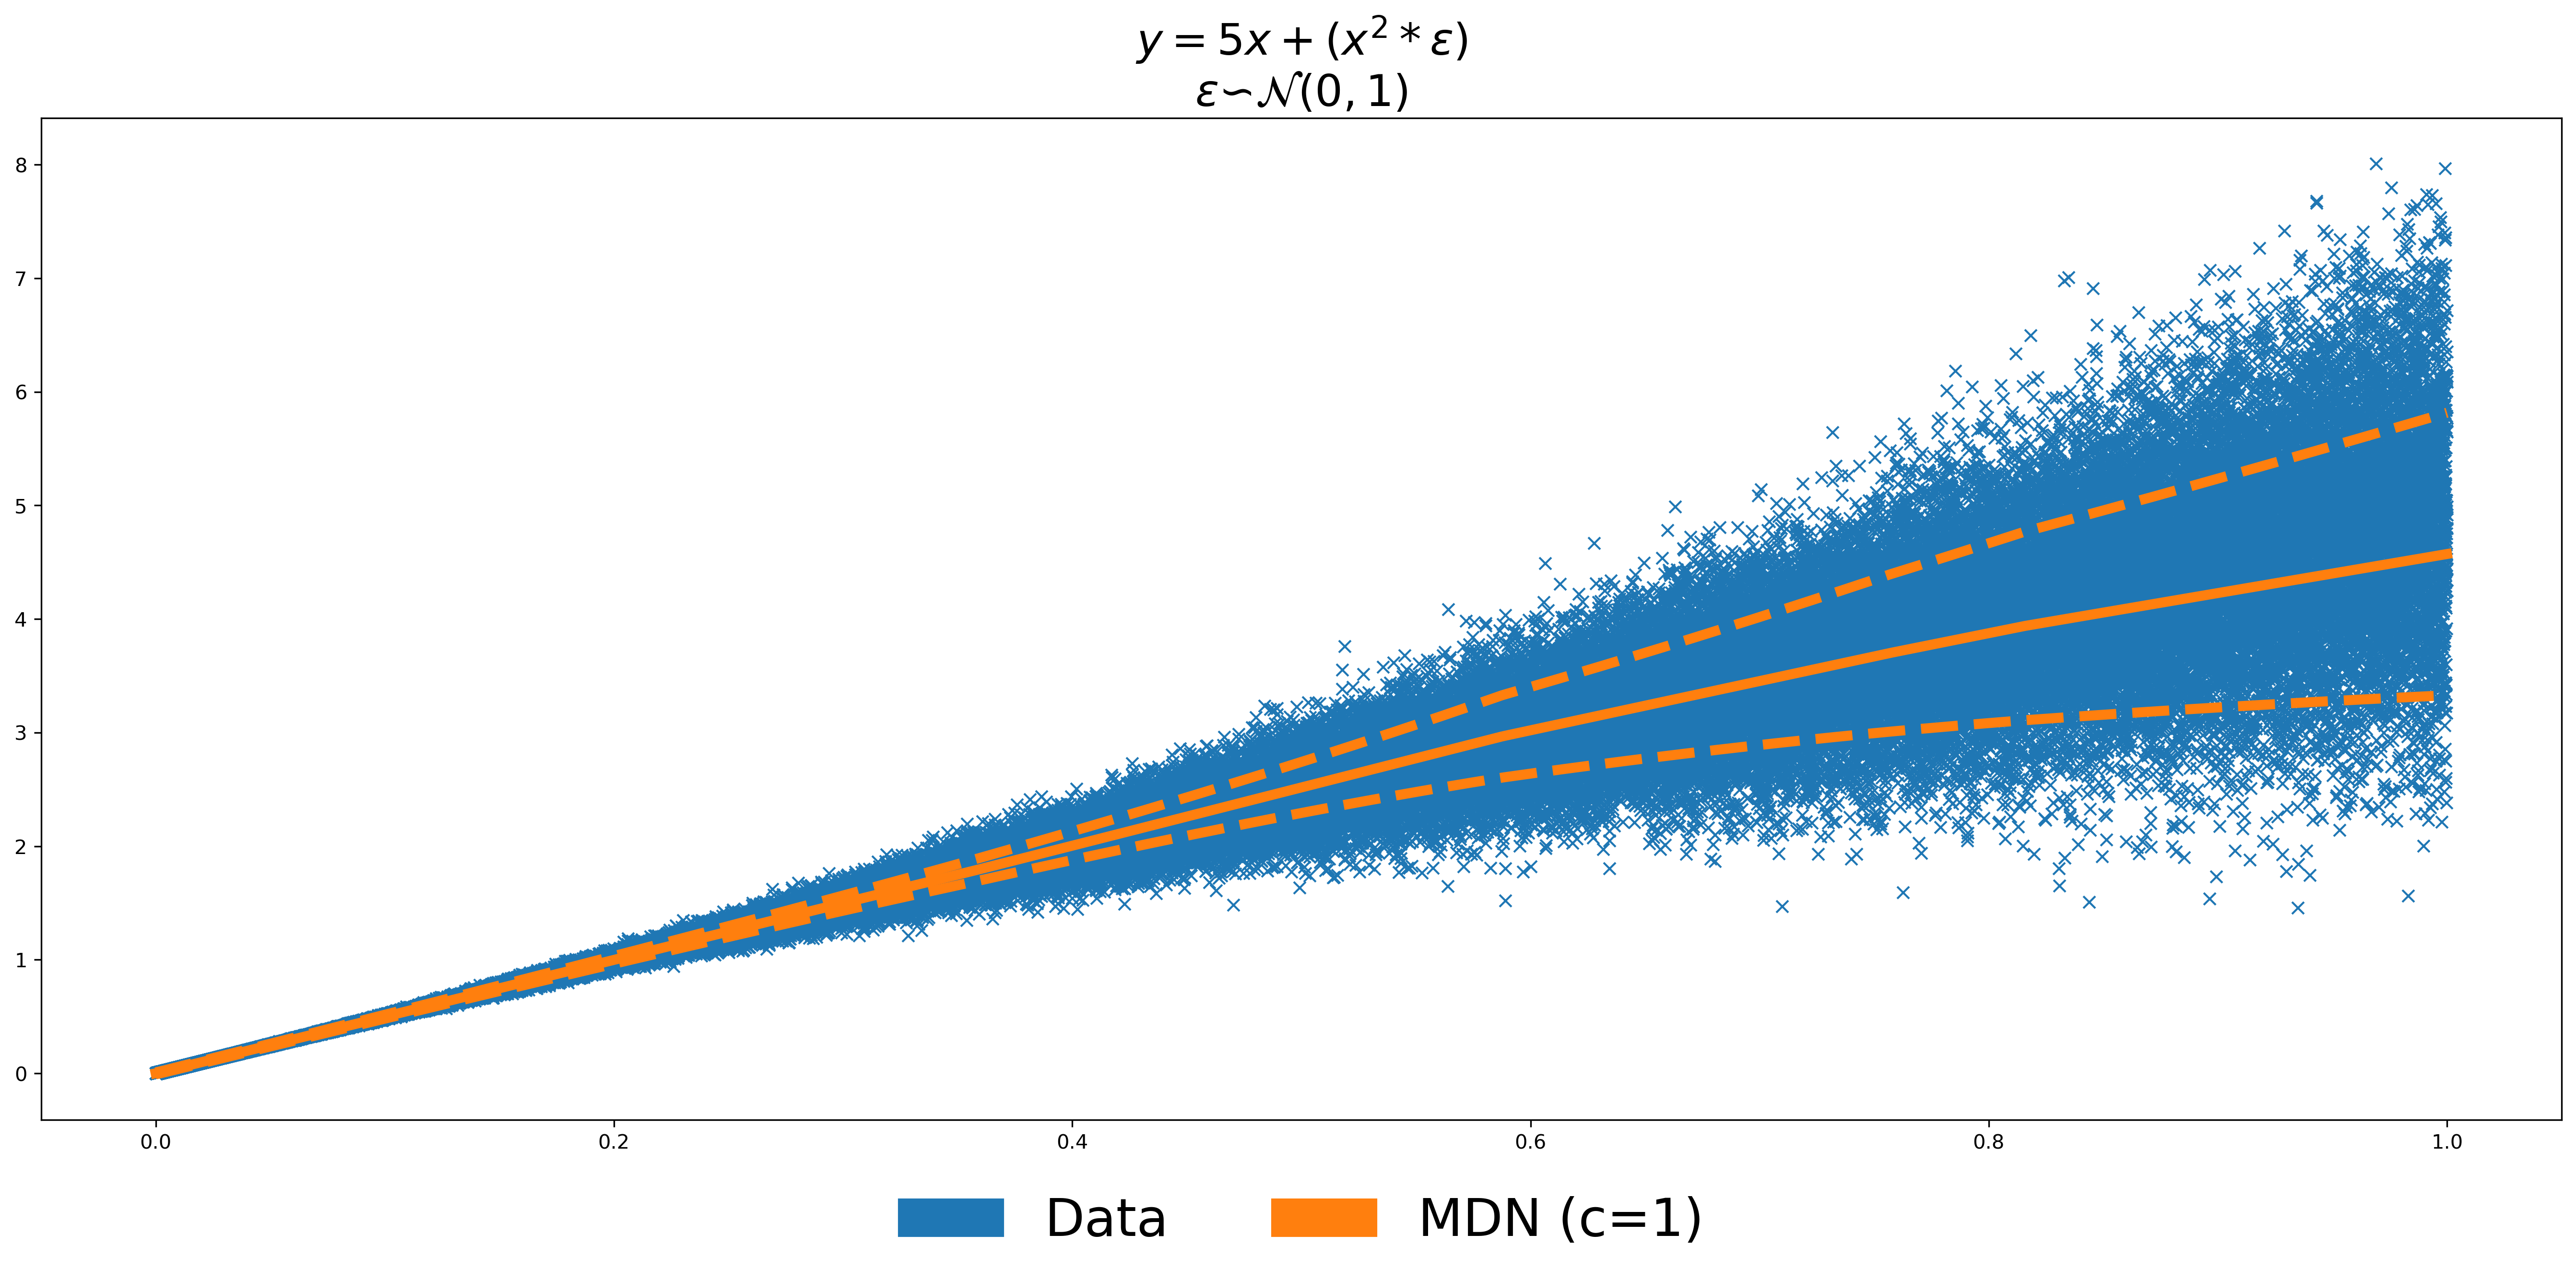

In [12]:
# Display the generated predictions
linear_mdn.eval()
s = torch.from_numpy(np.linspace(0.,1.,1000)[:, np.newaxis]).to(device)
_, mu, sigma_tril = linear_mdn(s)

mu = mu.squeeze().detach().cpu()
sigma = sigma_tril.squeeze().detach().cpu()
s = s.cpu()

fig = plt.figure(figsize=(x_size, y_size), dpi=dpi)
ax = plt.gca()
ax.set_title(r"$y = 5x + (x^2 * \epsilon)$"+"\n"+r"$\epsilon \backsim \mathcal{N}(0,1)$", fontsize=22)
ax.plot(linear_x, linear_y, "x", alpha=1, color=sns.color_palette()[0])

plt.plot(s, mu + sigma, color=sns.color_palette()[1], linewidth=5, linestyle='--', markersize=3)
plt.plot(s, mu - sigma, color=sns.color_palette()[1], linewidth=5, linestyle='--', markersize=3)
plt.plot(s, mu, color=sns.color_palette()[1], linewidth=5, linestyle='-', markersize=3)

data_leg = mpatches.Patch(color=sns.color_palette()[0])
data_mdn = mpatches.Patch(color=sns.color_palette()[1])

ax.legend(handles = [data_leg, data_mdn], labels = ["Data", "MDN (c=1)"], loc=9, 
          borderaxespad=0.1, framealpha=1.0, fancybox=True, bbox_to_anchor=(0.5, -0.05), 
          ncol=2, shadow=True, frameon=False, fontsize=26)

plt.tight_layout()
plt.show()

# Nonlinear Example
This is the nonlinear 1-D example from [this blog](https://towardsdatascience.com/a-hitchhikers-guide-to-mixture-density-networks-76b435826cca).

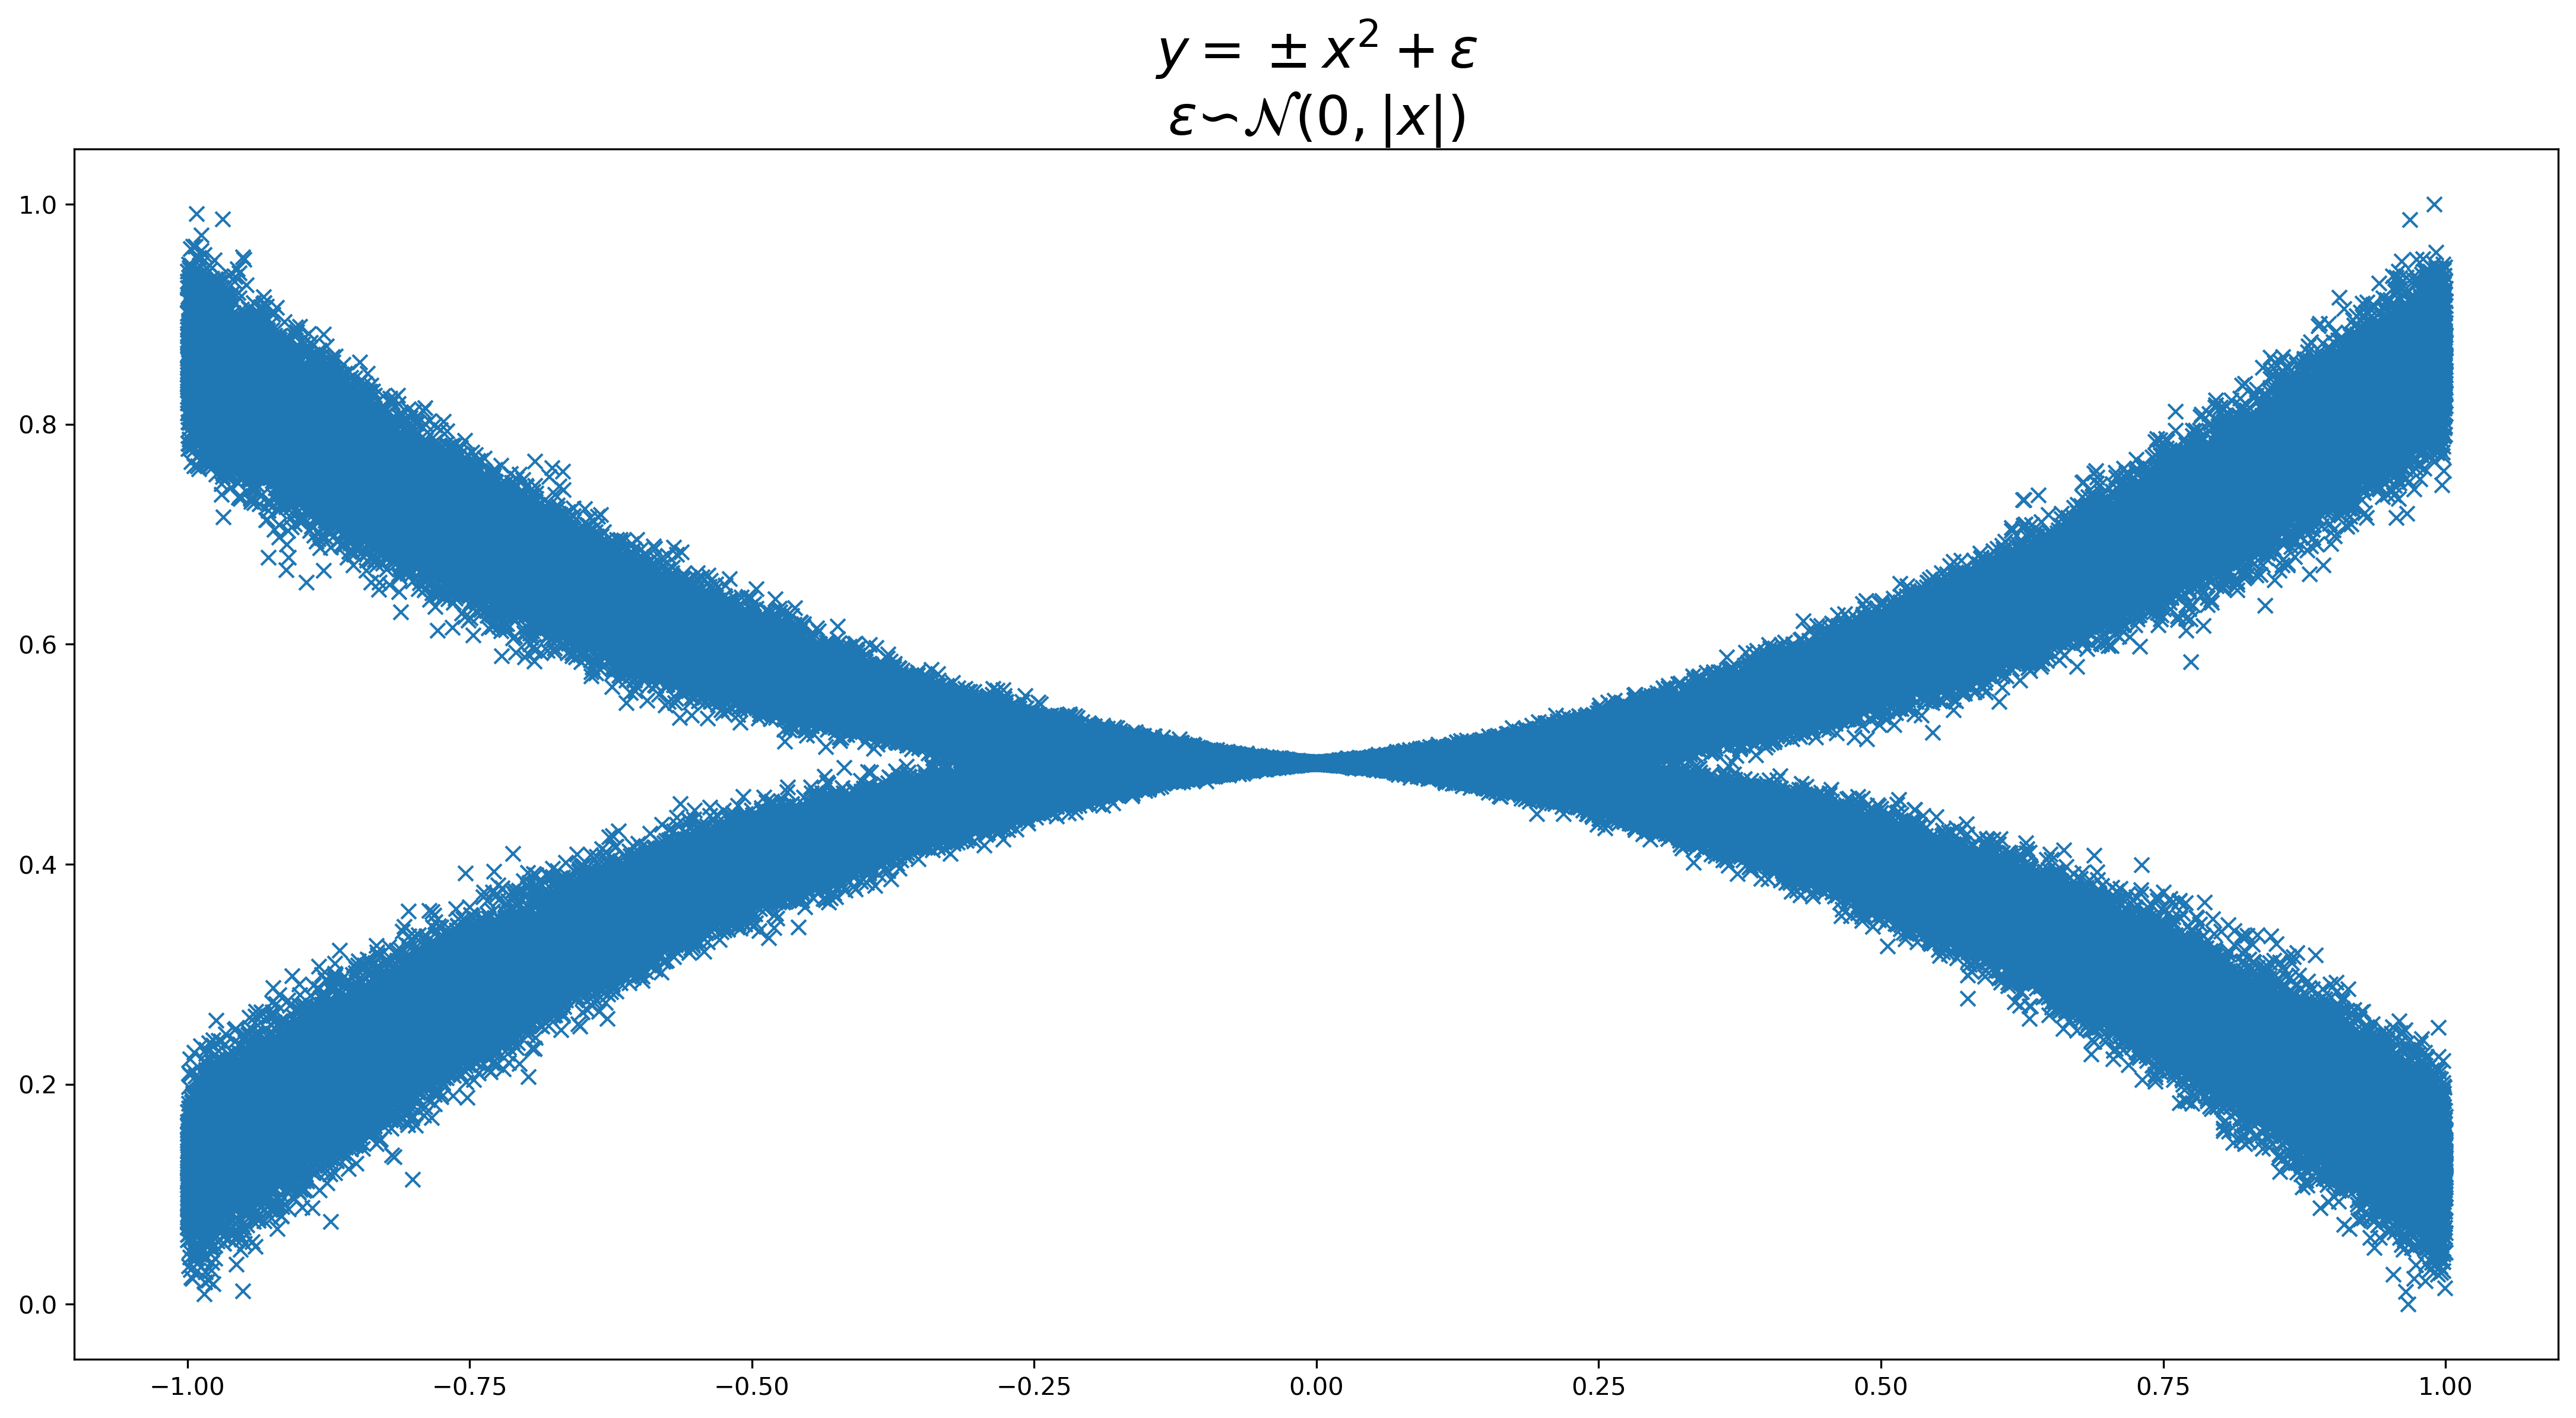

In [13]:
# Create training samples
n_samples = 100000

x1 = np.random.uniform(-1, 1, (1, n_samples))
r1 = np.array([np.random.normal(scale=np.abs(i)) for i in x1])
y1 = np.square(x1) + r1 * .1

x2 = np.float32(np.random.uniform(-1, 1, (1, n_samples)))
r2 = np.array([np.random.normal(scale=np.abs(i)) for i in x2])
y2 = np.float32(-np.square(x2) + r2 * .1)

nonlinear_x = np.concatenate((x1, x2), axis=1).T
nonlinear_y = np.concatenate((y1, y2), axis=1).T

min_max_scaler = MinMaxScaler()
nonlinear_y = min_max_scaler.fit_transform(nonlinear_y)

fig = plt.figure(figsize=(x_size, y_size), dpi=dpi)
ax = plt.gca()
ax.set_title(r"$y = \pm x^2 + \epsilon$"+"\n"+r"$\epsilon\backsim\mathcal{N}(0,|x|)$", fontsize=22)
ax.plot(nonlinear_x, nonlinear_y, "x", alpha=1., color=sns.color_palette()[0])
plt.show()

In [24]:
# Create the model and data loader
device = 'cuda'
learning_rate = 1e-3
n_epochs = 100
batch_size = 2048
n_components = 2
n_hidden = 32
n_layers = 2
activation = 'relu'
norm = None

nonlinear_dataset = MDNDataset(nonlinear_x, nonlinear_y)
nonlinear_loader = DataLoader(nonlinear_dataset, batch_size=batch_size, shuffle=True)

nonlinear_mdn = MDN(1, 1, [n_hidden]*n_layers, n_components, activation, norm).to(device).double()
optim = Adam(nonlinear_mdn.parameters(), lr=learning_rate)
nonlinear_mdn.train()

MDN(
  (mlp): MLP(
    (layers): ModuleList(
      (0): LinearBlock(
        (layers): ModuleList(
          (0): Linear(in_features=1, out_features=32, bias=True)
          (1): ReLU()
        )
      )
      (1): LinearBlock(
        (layers): ModuleList(
          (0): Linear(in_features=32, out_features=32, bias=True)
          (1): ReLU()
        )
      )
      (2): LinearBlock(
        (layers): ModuleList(
          (0): Linear(in_features=32, out_features=32, bias=True)
        )
      )
    )
  )
  (alpha): LinearBlock(
    (layers): ModuleList(
      (0): Linear(in_features=32, out_features=2, bias=True)
    )
  )
  (mu): LinearBlock(
    (layers): ModuleList(
      (0): Linear(in_features=32, out_features=2, bias=True)
    )
  )
  (L_diag): LinearBlock(
    (layers): ModuleList(
      (0): Linear(in_features=32, out_features=2, bias=True)
      (1): Softplus(beta=1, threshold=20)
    )
  )
)

In [25]:
# Train the model
for epoch in range(n_epochs):
    running_loss = 0
    for x, y in nonlinear_loader:
        alpha, mu, sigma_tril = nonlinear_mdn(x.to(device))
        loss = mdn_loss(y.to(device), alpha, mu, sigma_tril)
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        running_loss += loss.item()
        
    print(f"E{epoch+1}: {running_loss / (epoch + 1):.3f}")

E1: -10.961
E2: -78.762
E3: -66.798
E4: -51.140
E5: -41.158
E6: -34.548
E7: -29.653
E8: -26.158
E9: -23.246
E10: -20.980
E11: -19.098
E12: -17.573
E13: -16.251
E14: -15.035
E15: -13.888
E16: -13.243
E17: -12.451
E18: -11.764
E19: -11.152
E20: -10.589
E21: -10.117
E22: -8.366
E23: -9.273
E24: -8.869
E25: -8.542
E26: -7.957
E27: -7.919
E28: -7.625
E29: -7.362
E30: -5.448
E31: -5.198
E32: -6.242
E33: -6.406
E34: -6.268
E35: -5.589
E36: -5.930
E37: -5.799
E38: -5.644
E39: -4.265
E40: -3.654
E41: -4.773
E42: -4.885
E43: -4.879
E44: -4.852
E45: -4.763
E46: -4.672
E47: 0.430
E48: -1.095
E49: -1.794
E50: -2.513
E51: -3.139
E52: -3.427
E53: -3.577
E54: -3.662
E55: -3.686
E56: -3.676
E57: -3.650
E58: -3.612
E59: -3.563
E60: -3.511
E61: -3.462
E62: -3.411
E63: -3.365
E64: -3.319
E65: -3.275
E66: -3.226
E67: -3.169
E68: -3.138
E69: -3.088
E70: -3.046
E71: -3.013
E72: -2.951
E73: -2.929
E74: -2.891
E75: -2.838
E76: -2.810
E77: -2.780
E78: -2.003
E79: -2.151
E80: -2.565
E81: -2.616
E82: -2.610
E83: 

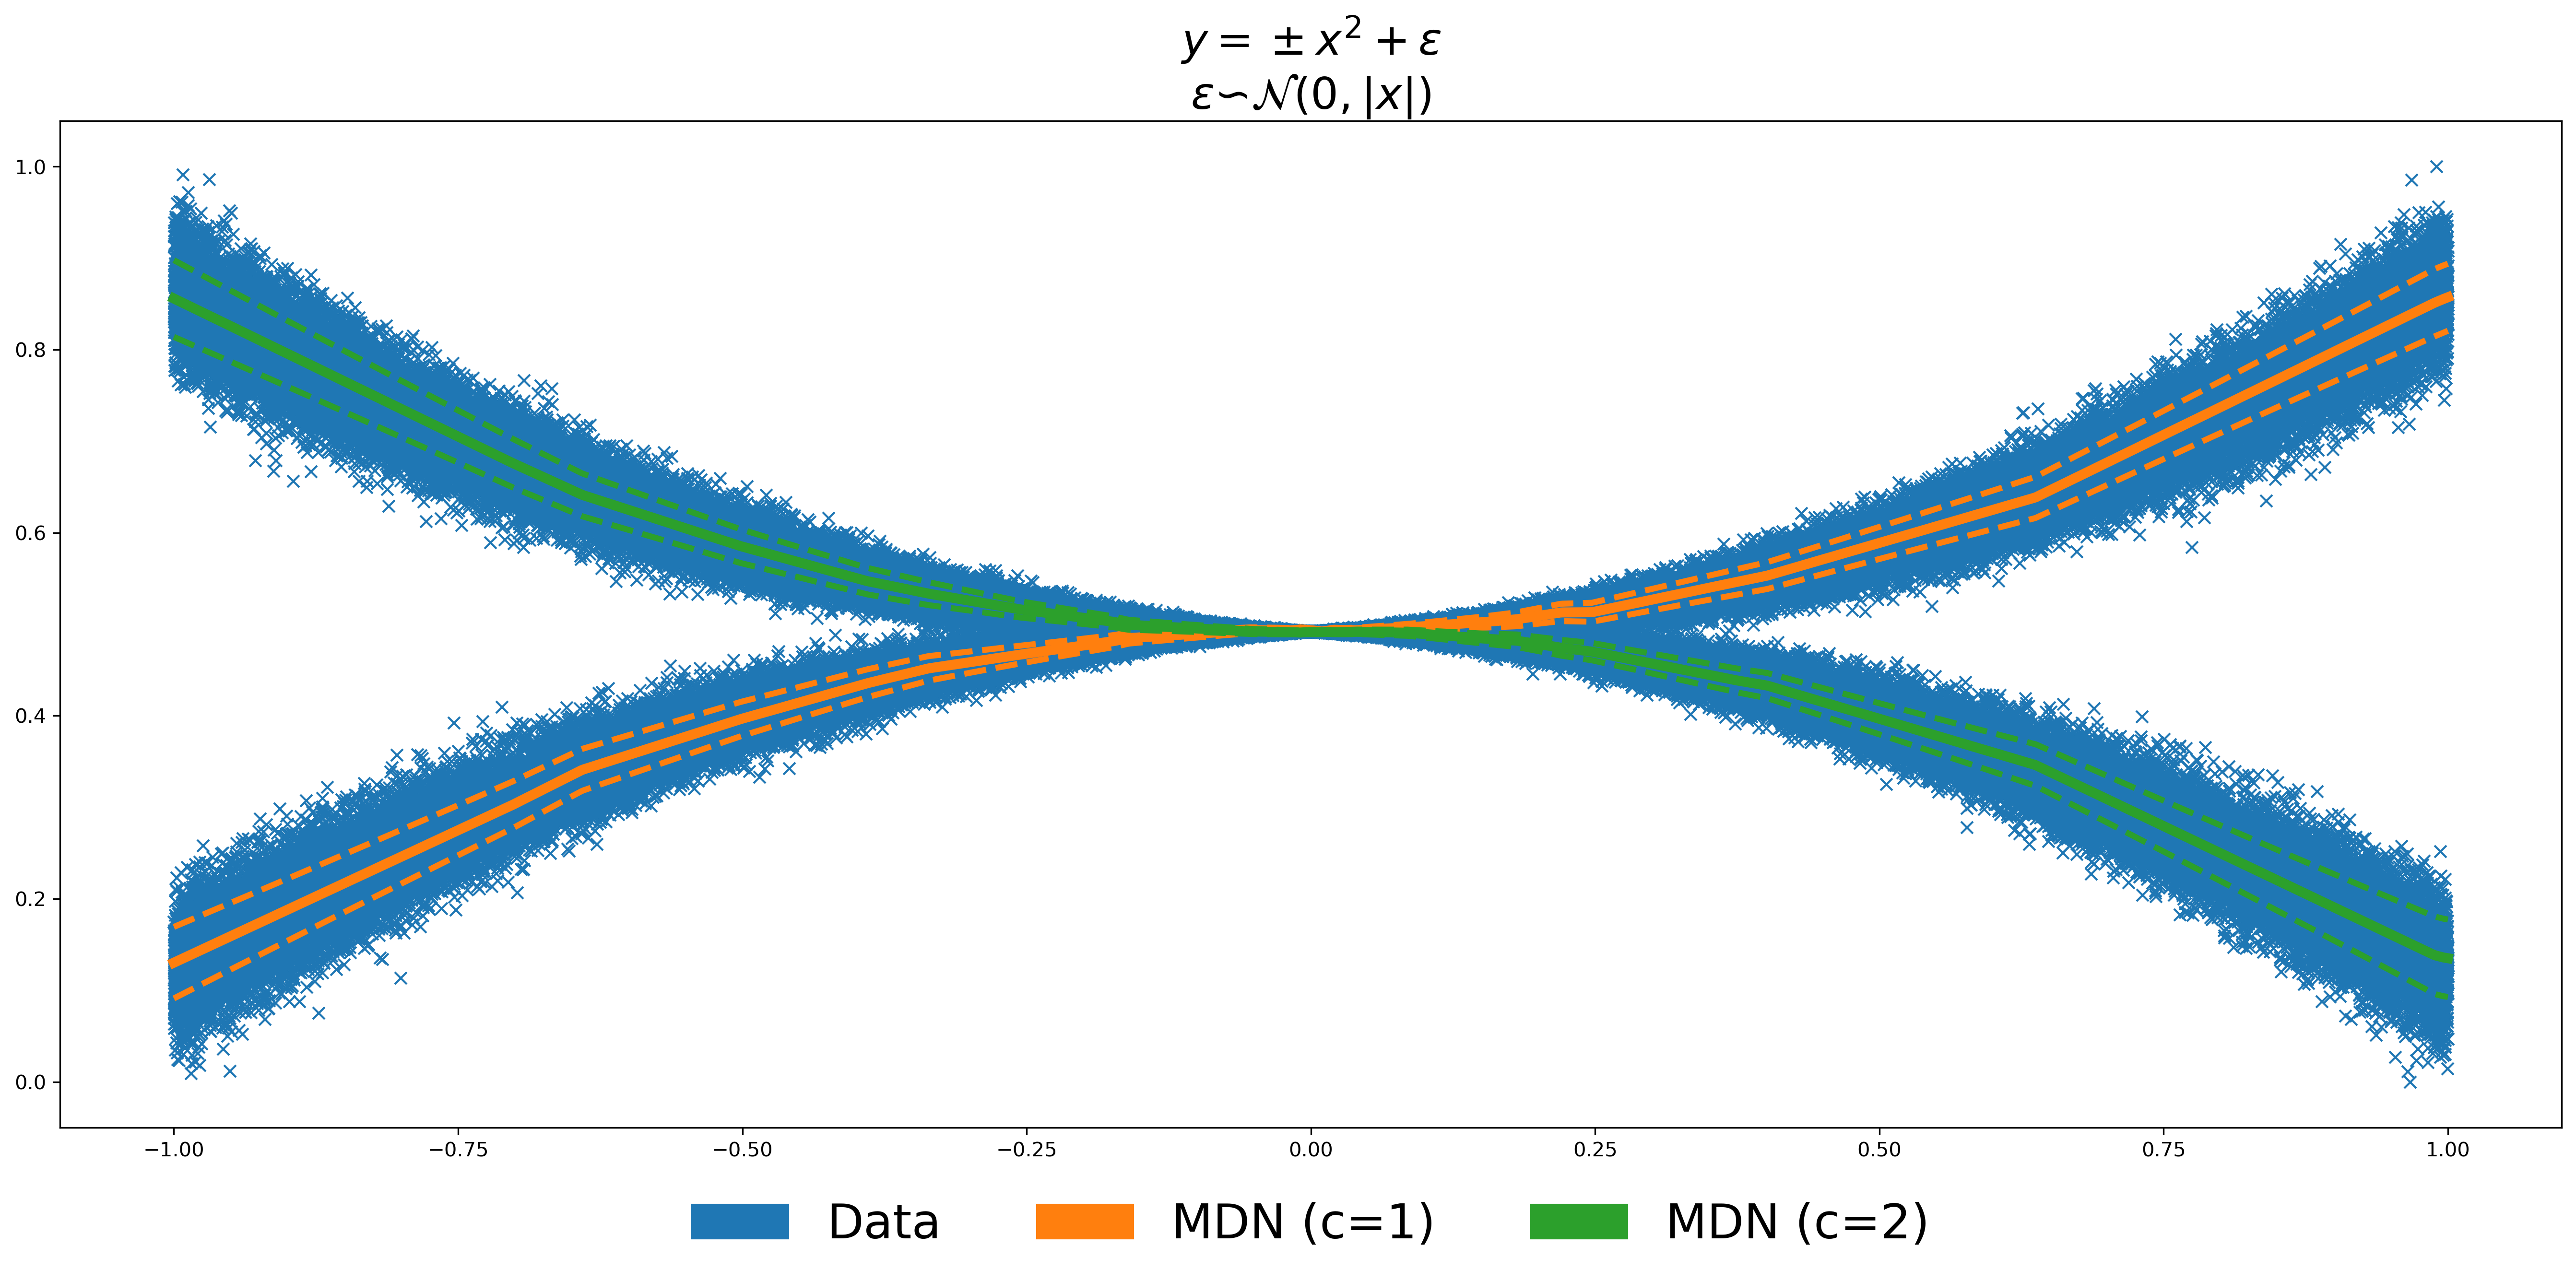

In [26]:
# Display the generated predictions
nonlinear_mdn.eval()
s = torch.from_numpy(np.linspace(-1, 1, 1000)[:, np.newaxis]).to(device)
_, mu, sigma_tril = nonlinear_mdn(s)

mu = mu.detach().cpu()
sigma = sigma_tril.squeeze(1).detach().cpu()
s = s.cpu()

fig = plt.figure(figsize=(x_size, y_size), dpi=dpi)
ax = plt.gca()
ax.set_title(r"$y = \pm x^2 + \epsilon$"+"\n"+r"$\epsilon\backsim\mathcal{N}(0,|x|)$", fontsize=22)
ax.plot(nonlinear_x, nonlinear_y, "x",alpha=1, color=sns.color_palette()[0])

for mx in range(n_components):
    plt.plot(s, mu[:,:,mx], color=sns.color_palette()[1+mx], linewidth=5, linestyle='-', markersize=3)
    plt.plot(s, mu[:,:,mx] - sigma[:,:,mx], color=sns.color_palette()[1+mx], linewidth=3, linestyle='--', markersize=3)
    plt.plot(s, mu[:,:,mx] + sigma[:,:,mx], color=sns.color_palette()[1+mx], linewidth=3, linestyle='--', markersize=3)

data_leg = mpatches.Patch(color=sns.color_palette()[0])
data_mdn1 = mpatches.Patch(color=sns.color_palette()[1])
data_mdn2 = mpatches.Patch(color=sns.color_palette()[2])

ax.legend(handles = [data_leg, data_mdn1, data_mdn2], labels = ["Data", "MDN (c=1)", "MDN (c=2)"],
          loc=9, borderaxespad=0.1, framealpha=1.0, fancybox=True, bbox_to_anchor=(0.5, -0.05), 
          ncol=6, shadow=True, frameon=False, fontsize=24)
plt.tight_layout()
plt.show()

# 2-D Example

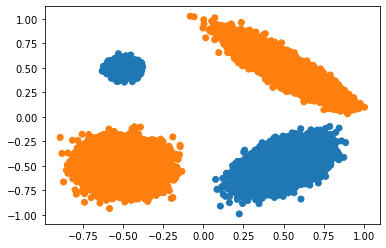

In [42]:
n_samples = 100000

cov1 = 0.001*torch.eye(2).double()
cov2 = 0.01*torch.eye(2).double()
cov3 = 0.01*torch.eye(2).double()
cov2[0, 1] = 0.005
cov2[1, 0] = 0.005
cov4 = 0.017*torch.eye(2).double()
cov4[0, 1] = -0.015
cov4[1, 0] = -0.015
gauss1 = D.MultivariateNormal(torch.from_numpy(np.array([-0.5, 0.5])).double(), cov1)
gauss2 = D.MultivariateNormal(torch.from_numpy(np.array([0.5, -0.5])).double(), cov2)
gauss3 = D.MultivariateNormal(torch.from_numpy(np.array([-0.5, -0.5])).double(), cov3)
gauss4 = D.MultivariateNormal(torch.from_numpy(np.array([0.5, 0.5])).double(), cov4)

samples = []
for _ in range(n_samples):
    x = np.random.random()
    if x < 0.25:
        samples.append((torch.tensor(0).double(), gauss1.sample()))
    elif x < 0.5:
        samples.append((torch.tensor(0).double(), gauss2.sample()))
    elif x < 0.75:
        samples.append((torch.tensor(1).double(), gauss3.sample()))
    else:
        samples.append((torch.tensor(1).double(), gauss4.sample()))
        
gmm2d_x = torch.stack([s[0] for s in samples]).unsqueeze(-1).numpy()
gmm2d_y = torch.stack([s[1] for s in samples]).numpy()

colors = np.round(gmm2d_x).tolist()
colors = [sns.color_palette()[int(i)] for i in np.round(gmm2d_x).flatten()]

plt.scatter(gmm2d_y[:,0], gmm2d_y[:,1], color=colors)
plt.show()

In [43]:
device = 'cpu'
learning_rate = 1e-3
n_epochs = 100
batch_size = 2048
n_components = 2
n_hidden = 32
n_layers = 2
activation = 'relu'
norm = None
diag_only = False

gmm2d_dataset = MDNDataset(gmm2d_x, gmm2d_y)
gmm2d_loader = DataLoader(gmm2d_dataset, batch_size=batch_size, shuffle=True)

gmm2d_mdn = MDN(1, 2, [n_hidden]*n_layers, n_components, activation, norm, diag_only).to(device).double()
optim = Adam(gmm2d_mdn.parameters(), lr=learning_rate)
gmm2d_mdn.train()

MDN(
  (mlp): MLP(
    (layers): ModuleList(
      (0): LinearBlock(
        (layers): ModuleList(
          (0): Linear(in_features=1, out_features=32, bias=True)
          (1): ReLU()
        )
      )
      (1): LinearBlock(
        (layers): ModuleList(
          (0): Linear(in_features=32, out_features=32, bias=True)
          (1): ReLU()
        )
      )
      (2): LinearBlock(
        (layers): ModuleList(
          (0): Linear(in_features=32, out_features=32, bias=True)
        )
      )
    )
  )
  (alpha): LinearBlock(
    (layers): ModuleList(
      (0): Linear(in_features=32, out_features=2, bias=True)
    )
  )
  (mu): LinearBlock(
    (layers): ModuleList(
      (0): Linear(in_features=32, out_features=4, bias=True)
    )
  )
  (L_diag): LinearBlock(
    (layers): ModuleList(
      (0): Linear(in_features=32, out_features=4, bias=True)
      (1): Softplus(beta=1, threshold=20)
    )
  )
  (L): LinearBlock(
    (layers): ModuleList(
      (0): Linear(in_features=32, out_f

In [44]:
for epoch in range(n_epochs):
    running_loss = 0
    for x, y in gmm2d_loader:
        alpha, mu, sigma_tril = gmm2d_mdn(x.to(device))
        loss = mdn_loss(y.to(device), alpha, mu, sigma_tril)
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        running_loss += loss.item()
        
    print(f"E{epoch+1}: {running_loss / (epoch + 1):.3f}")

E1: 63.386
E2: 2.238
E3: -5.479
E4: -8.270
E5: -11.236
E6: -13.589
E7: -12.106
E8: -10.615
E9: -9.428
E10: -8.499
E11: -7.728
E12: -7.086
E13: -6.532
E14: -6.072
E15: -5.678
E16: -5.321
E17: -5.009
E18: -4.739
E19: -4.472
E20: -4.254
E21: -4.055
E22: -3.867
E23: -3.701
E24: -3.542
E25: -3.407
E26: -3.273
E27: -3.144
E28: -3.043
E29: -2.928
E30: -2.842
E31: -2.749
E32: -2.662
E33: -2.580
E34: -2.495
E35: -2.432
E36: -2.366
E37: -2.302
E38: -2.246
E39: -2.183
E40: -2.125
E41: -2.078
E42: -2.024
E43: -1.975
E44: -1.931
E45: -1.890
E46: -1.851
E47: -1.811
E48: -1.774
E49: -1.741
E50: -1.706
E51: -1.667
E52: -1.642
E53: -1.603
E54: -1.577
E55: -1.551
E56: -1.523
E57: -1.493
E58: -1.470
E59: -1.444
E60: -1.418
E61: -1.393
E62: -1.373
E63: -1.352
E64: -1.330
E65: -1.310
E66: -1.290
E67: -1.271
E68: -1.253
E69: -1.235
E70: -1.217
E71: -1.200
E72: -1.183
E73: -1.168
E74: -1.153
E75: -1.136
E76: -1.122
E77: -1.107
E78: -1.092
E79: -1.080
E80: -1.062
E81: -1.051
E82: -1.038
E83: -1.028
E84: -1.01

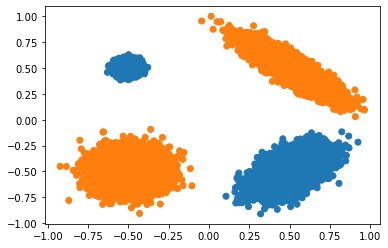

In [45]:
n_points = 10000

colors = np.round(gmm2d_x).tolist()
colors = [sns.color_palette()[int(i)] for i in np.round(gmm2d_x).flatten()]
#plt.scatter(y_data[:,0], y_data[:,1], color=colors)

gmm2d_mdn.eval().cpu()
s = torch.tensor([0, 1]).unsqueeze(-1).double().cpu()
_, mu, sigma_tril = gmm2d_mdn(s)
mu = mu.detach().cpu()
sigma = sigma_tril.detach().cpu()

points = []
colors = []
for i in range(n_components):
    gauss = D.MultivariateNormal(loc=mu[:,:,i], scale_tril=sigma[:,:,:,i])
    for _ in range(n_points):
        sample = gauss.sample()
        for j in range(2):  # Each 'batch' is either input 0 or 1
            points.append(sample[j])
            colors.append(sns.color_palette()[j])
        
points = torch.stack(points).numpy()
    
plt.scatter(points[:,0], points[:,1], color=colors)
plt.show()